# Info

https://www.kaggle.com/datasets/ahmedabelal/arabic-poetry

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

In [4]:
import os
import re
import json
import random

In [5]:
import tqdm
import pickle

In [6]:
!pip install arabic-reshaper python-bidi
import arabic_reshaper
from bidi.algorithm import get_display

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Functions

In [9]:
def count_n_lines(text):
    return len(text.split('\n'))

In [10]:
def count_n_words(text):
    return len(text.split(' '))

In [11]:
def count_n_chars(text):
    return len(text)

In [12]:
def read_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def write_json(path, data):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [13]:
def read_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def write_pickle(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

# Constants

In [14]:
WINDOW_SIZE = 64 # Words, will be 65 by adding CLS token

In [15]:
START_TOKEN = '#'
CONCAT_TOKEN = '&'
CLS_TOKEN = '$'
OOV_TOKEN = 'OOV'

In [16]:
# BASE_DIR = 'drive/MyDrive/BBB'
BASE_DIR = ''

UTILS_DIR = os.path.join(BASE_DIR, 'utils')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')

os.makedirs(UTILS_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)

TOKENIZER_PATH = os.path.join(UTILS_DIR, 'tokenizer.pickle')
TOKENS_DICT_PATH = os.path.join(UTILS_DIR, 'tokens.json')

In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [18]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [19]:
EPOCHS = 10
BATCH_SIZE = 1024

# Data Loading

In [20]:
# Download latest version
path = kagglehub.dataset_download("ahmedabelal/arabic-poetry")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\yosef\.cache\kagglehub\datasets\ahmedabelal\arabic-poetry\versions\1


In [21]:
os.listdir(path), path

(['Arabic_poetry_dataset.csv'],
 'C:\\Users\\yosef\\.cache\\kagglehub\\datasets\\ahmedabelal\\arabic-poetry\\versions\\1')

In [22]:
df = pd.read_csv(os.path.join(path, os.listdir(path)[0] ))

# Dataset Exploration

In [23]:
pd.concat([df.head(), df.sample(5), df.tail()])

,id,category,poet_name,poem_title,poem_text
0,0,الإمارات,خلفان بن مصبح,بدت تختال في حُلل الجمالِ,بدت تختال في حُلل الجمالِ\nوجادت بالزيارة والو...
1,1,الإمارات,خلفان بن مصبح,يا طائر الشعر القرير,يا طائر الشعر القرير\nيا وحي إلهام الصدور\nأسع...
2,2,الإمارات,خلفان بن مصبح,بنت حجرات أرى من عجب,بنت حجرات أرى من عجب\nأن أرى فيك جمال العرب\nد...
3,3,الإمارات,خلفان بن مصبح,هذا الربيع بنور الحسن وافانا,هذا الربيع بنور الحسن وافانا\nوقد كسا الأرض با...
4,4,الإمارات,خلفان بن مصبح,روحي فداك وإن مُنحتُ صدوداً,روحي فداك وإن مُنحتُ صدوداً\nأخفاك ما بي أم أط...
16765,16939,العصر العباسي,أبو العلاء المعري,سكنت إلى الدنيا فلما عرفتها,سَكَنتُ إِلى الدُنيا فَلَمّا عَرَفتُها\nتَمَنّ...
11400,11574,مصر,مصطفى صادق الرافعي,آفة العالم أن لا يعملا,آفةُ العالمِ أن لا يعملا\nوشقا الجاهلِ أن لا ي...
37613,37787,عصر المخضرمون,علي بن أبي طالب,أبى الله إلا أن صفين دارنا,أَبى اللَهُ إِلّا أَنَّ صِفِّينَ دارُنا\nوَدار...
13700,13874,العصر الجاهلي,الخنساء,يا عين جودي بالدموع,يا عَينِ جودي بِالدُموعِ \nالمُستَهِلّاتِ السَ...
3272,3379,اليمن,محمد الشوكاني,كأن وجه النهر إذ حفت به,كَأَنَّ وَجْهَ النَّهْرِ إذْ حَفَّتْ بِهِ\nأَش...


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54944 entries, 0 to 54943
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54944 non-null  int64 
 1   category    54944 non-null  object
 2   poet_name   54944 non-null  object
 3   poem_title  54944 non-null  object
 4   poem_text   54944 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [25]:
df.describe(include='all')

,id,category,poet_name,poem_title,poem_text
count,54944.000000,54944,54944,54944,54944
unique,NaN,28,538,54300,54767
top,NaN,العصر العباسي,ابن نباته المصري,إذا المشكلات تصدين لي,أنتَ في حِلٍّ وَفي سَعَةٍ\nمِن دَمِي يَا مَن ت...
freq,NaN,10116,1726,4,2
mean,27636.214673,NaN,NaN,NaN,NaN
std,15875.618346,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN
25%,13909.750000,NaN,NaN,NaN,NaN
50%,27645.500000,NaN,NaN,NaN,NaN
75%,41381.250000,NaN,NaN,NaN,NaN


# Data Preprocessing

In [26]:
def clean_poem_text(txt):
    # Normalize Arabic forms to standard letters
    arabic_normalization = {
        "أ": "ا",
        "إ": "ا",
        "آ": "ا",
        "ؤ": "و",
        "ئ": "ي",
        "ى": "ي",
        "ة": "ه",
        "ۀ": "ه",
        "گ": "ك",
        "پ": "ب",
        "چ": "ج",
        "ژ": "ز",
        "ی": "ي",
    }

    for k, v in arabic_normalization.items():
        txt = txt.replace(k, v)

    # Remove Tatweel (ـ)
    txt = txt.replace("ـ", "")

    # Remove diacritics (tashkeel)
    txt = re.sub(r'[\u064B-\u0652]', '', txt)

    # Remove English letters and digits
    txt = re.sub(r'[A-Za-z0-9]', '', txt)

    # Remove non-Arabic punctuation except (، ؛ ؟)
    txt = re.sub(r'[^\u0600-\u06FF\n،؛؟ ]', '', txt)

    txt = re.sub(r'([،؛؟])', r' \1 ', txt)

    # Reduce duplicated alif
    txt = re.sub(r'[ا]{2,}', 'ا', txt)

    # ---- Decompose known prefixes ----
    prefixes = [
        "وال", "فال", "كال", "بال", "لل",
        "ال", "و", "ف", "ب", "ك", "ل", "س"
    ]

    for pre in sorted(prefixes, key=len, reverse=True):
        txt = re.sub(rf'\b({pre})(?=[\u0621-\u064A])', rf'\1 {CONCAT_TOKEN} ', txt)

    # ---- Decompose known suffixes ----
    suffixes = [
        "كما", "كم", "كن", "نا", "هم", "هن", "ها", "هو",
        "ك", "ي", "ا", "و"
    ]

    for suf in sorted(suffixes, key=len, reverse=True):
        txt = re.sub(rf'([\u0621-\u064A]+)({suf})\b', rf'\1 {CONCAT_TOKEN} \2', txt)

    # ---- Handle mid-word merges (like رعاءابو / هواءتالف / ثواءمكان) ----
    # Detect if two Arabic word parts (each ≥3 letters) are glued together
    txt = re.sub(
        r'([\u0621-\u064A]{3,})(?=[اأإآببتثجحخدذرزسشصضطظعغفقكلمنهوية]{3,})',
        rf'\1 {CONCAT_TOKEN} ',
        txt
    )

    # Extra decomposition (for special double-l patterns)
    txt = re.sub(r'\b(ال)(\w+)', r'\1' + f' {CONCAT_TOKEN} ' + '\2', txt)
    txt = re.sub(r'\b(لل)(\w+)', r'\1' + f' {CONCAT_TOKEN} ' + '\2', txt)
    txt = re.sub(r'(\w+)(ك|هم|نا|ها|ه|ي|كم|كن)\b', r'\1' + f' {CONCAT_TOKEN} ' + '\2', txt)

    # ---- Clean invisible / control chars ----
    txt = re.sub(r'[\u0000-\u0008\u000B-\u000C\u000E-\u001F\u007F]', ' ', txt)
    txt = re.sub(r'[\t]', ' ', txt)
    txt = re.sub(r'[\n]{2,}', '\n', txt)
    txt = re.sub(r'[\n]', ' \n ', txt)
    txt = re.sub(r'[ ]{2,}', ' ', txt)

    return txt.strip()

In [27]:
def compose_poem_text(txt):
  txt = txt.replace(f' {CONCAT_TOKEN} ', '')
  txt = txt.replace(f'{CONCAT_TOKEN} ', '')
  txt = txt.replace(f'{CONCAT_TOKEN}', '')
  txt = txt.replace(f'{START_TOKEN}', '')
  txt = txt.replace(f'{CLS_TOKEN}', '')

  return txt.strip()

In [28]:
df['poem_text'] = df['poem_text'].apply(clean_poem_text)

In [29]:
df['category'] = df['category'].apply(clean_poem_text)

# Data Analysis

In [30]:
df['poem_n_lines'] = df['poem_text'].apply(count_n_lines)

In [31]:
df['poem_n_chars'] = df['poem_text'].apply(count_n_chars)

In [32]:
df['poem_n_words'] = df['poem_text'].apply(count_n_words)

# Data Visualization

In [33]:
plt.style.use(plt.style.available[12])

<Axes: title={'center': 'Distribution of Number of Lines per Poem'}, xlabel='poem_n_lines', ylabel='Count'>

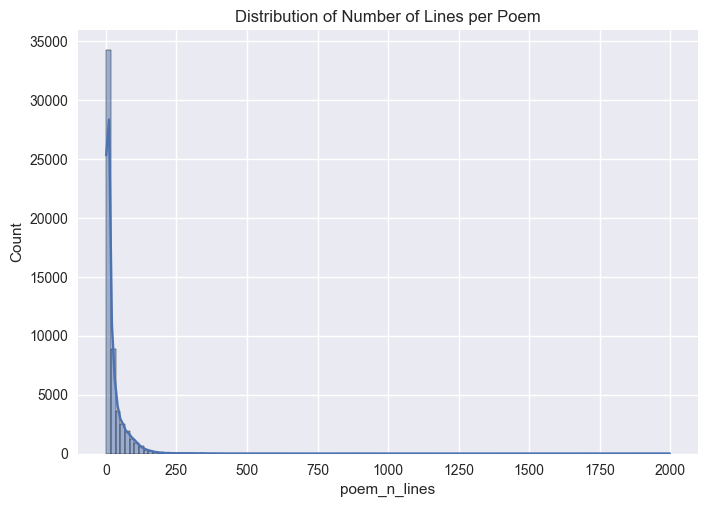

In [34]:
plt.title("Distribution of Number of Lines per Poem")
sns.histplot(data=df, x='poem_n_lines', bins=120, kde=True)

<Axes: title={'center': 'Distribution of Number of Chars per Poem'}, xlabel='poem_n_chars', ylabel='Count'>

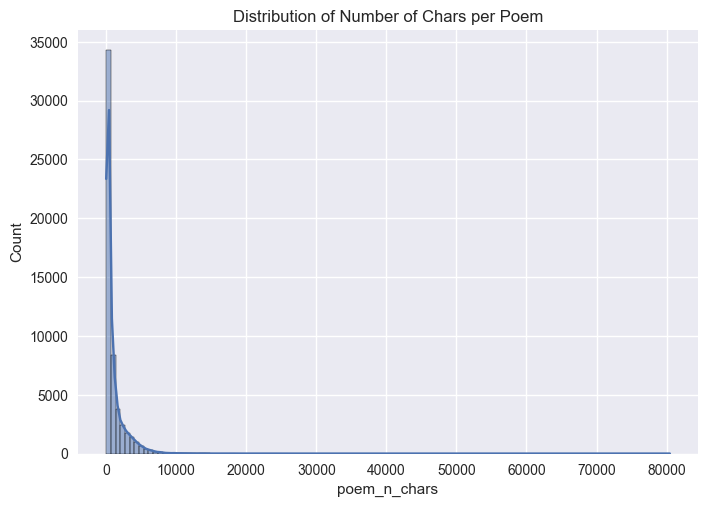

In [35]:
plt.title("Distribution of Number of Chars per Poem")
sns.histplot(data=df, x='poem_n_chars', bins=120, kde=True)

<Axes: title={'center': 'Distribution of Number of Words per Poem'}, xlabel='poem_n_words', ylabel='Count'>

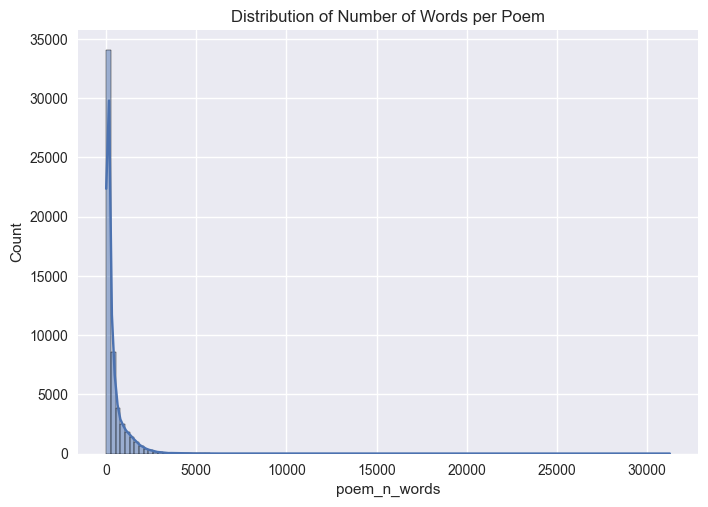

In [36]:
plt.title("Distribution of Number of Words per Poem")
sns.histplot(data=df, x='poem_n_words', bins=120, kde=True)

C:\Users\yosef\AppData\Local\Temp\ipykernel_3432\1514475348.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(reshaped_labels, rotation=45)


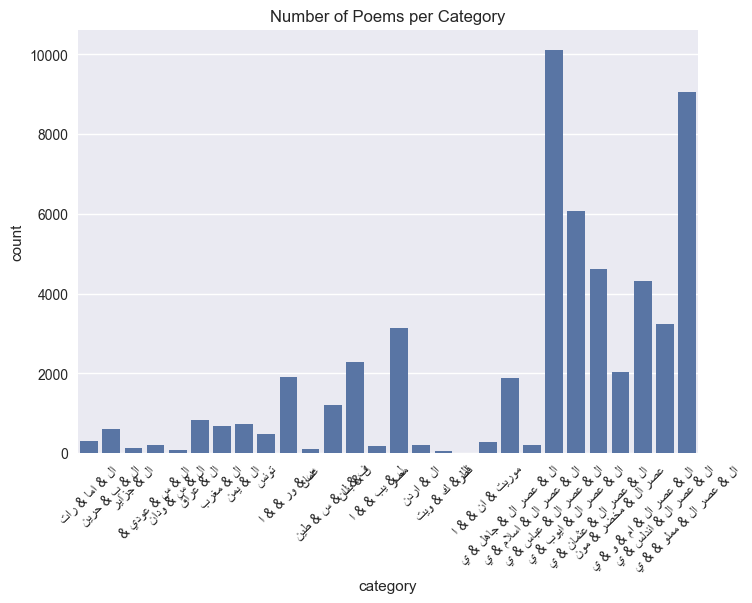

In [37]:
plt.title("Number of Poems per Category")
ax = sns.countplot(data=df, x='category')
plt.xticks(rotation=45)

labels = [t.get_text() for t in ax.get_xticklabels()]
reshaped_labels = [get_display(arabic_reshaper.reshape(l)) for l in labels]
ax.set_xticklabels(reshaped_labels, rotation=45)

plt.show()

# Tokenizer

In [48]:
if os.path.exists(TOKENIZER_PATH):
    tokenizer = read_pickle(TOKENIZER_PATH)
    print(f"Loaded existing tokenizer with {len(tokenizer.word_index)} tokens.")

else:
    tokenizer = Tokenizer(
        num_words=None,
        filters='',
        split=' ' ,
        oov_token = OOV_TOKEN,
        lower = False
    )

    tokenizer.fit_on_texts(tqdm.tqdm(df['poem_text'].tolist() + [START_TOKEN + ' ' + CONCAT_TOKEN + ' ' + CLS_TOKEN]))


    write_pickle(TOKENIZER_PATH, tokenizer)

    print(f"Created new tokenizer with {len(tokenizer.word_index)} tokens.")

tokenizer_dict = tokenizer.word_index

if START_TOKEN not in tokenizer_dict:
    tokenizer_dict = {word: idx+1 for word, idx in tokenizer_dict.items()}

write_json(TOKENS_DICT_PATH, tokenizer_dict)

Loaded existing tokenizer with 73776 tokens.


# Data Scanner

In [39]:
scanned_windows_df = []

In [40]:
def scan(data_frame):

  for idx, row in tqdm.tqdm(data_frame.iterrows(), total=data_frame.shape[0]):
      poem_id = row['id']
      poem_text = row['poem_text']

      poem_words = poem_text.split(' ')

      window_start_i = -1 * WINDOW_SIZE + 1

      while window_start_i < len(poem_words):
          window_end_i = window_start_i + WINDOW_SIZE

          if window_end_i >= len(poem_words):
              break

          pos_start = max(0, window_start_i)

          n_padds = min(0, window_start_i) * -1


          scanned_windows_df.append(
              {
                  'poem_id': poem_id,
                  'start_i': pos_start,
                  'end_i': window_end_i,
                  'n_padds': n_padds
              }
          )

          window_start_i += 1

In [41]:
scan(df)

100%|██████████| 54944/54944 [00:27<00:00, 2002.70it/s]


In [42]:
print("Converting to DataFrame")
scanned_windows_df = pd.DataFrame(scanned_windows_df)

Converting to DataFrame


In [43]:
scanned_windows_df

,poem_id,start_i,end_i,n_padds
0,0,0,1,63
1,0,0,2,62
2,0,0,3,61
3,0,0,4,60
4,0,0,5,59
...,...,...,...,...
22554931,55117,672,736,0
22554932,55117,673,737,0
22554933,55117,674,738,0
22554934,55117,675,739,0


# Data Split

In [44]:
scanned_windows_train, scanned_windows_df_test = train_test_split(
    scanned_windows_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

scanned_windows_df_val, scanned_windows_df_test = train_test_split(
    scanned_windows_df_test,
    test_size= TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED
)

In [45]:
print(f"Scanned Train len:  {len(scanned_windows_train):,}")
print(f"Scanned Val len:    {len(scanned_windows_df_val):,}")
print(f"Scanned Test len:   {len(scanned_windows_df_test):,}")

Scanned Train len:  18,043,948
Scanned Val len:    2,255,494
Scanned Test len:   2,255,494


# Data Loader

In [49]:
# Global cache shared across all DataLoader instances
_GLOBAL_POEM_CACHE = {}


class DataLoader(Sequence):
    def __init__(self, scanned_df, df, tokenizer_dict,
                 batch_size=BATCH_SIZE,
                 shuffle=True,
                 start_token=START_TOKEN,
                 tokenizer = tokenizer,
                 drop_random=0.0):

        global _GLOBAL_POEM_CACHE

        self.scanned_df = scanned_df.reset_index(drop=True)
        self.df = df
        self.tokenizer_dict = tokenizer_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_token = start_token
        self.drop_random = np.clip(drop_random, 0.0, 0.9)  # prevent full drop

        # Add new poems to the global cache (if not already cached)
        new_poems = df[~df['id'].isin(_GLOBAL_POEM_CACHE)]
        if len(new_poems) > 0:
            for poem_id, poem_text in zip(new_poems['id'].values, new_poems['poem_text'].values):
                _GLOBAL_POEM_CACHE[poem_id] = poem_text.split(' ')
            print(f"[DataLoader] Cached {len(new_poems)} new poems → total cache size: {len(_GLOBAL_POEM_CACHE)}")

        self.poem_cache = _GLOBAL_POEM_CACHE
        self.on_epoch_end()

    def __len__(self):
        effective_len = int(len(self.scanned_df) * (1 - self.drop_random))

        return max(1, effective_len // self.batch_size)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.scanned_df.iloc[batch_indices]

        poem_ids = batch_df['poem_id'].values
        starts = batch_df['start_i'].values
        ends = batch_df['end_i'].values
        padds = batch_df['n_padds'].values

        X, y = self._generate_pairs_fast(poem_ids, starts, ends, padds)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.scanned_df))

        if self.shuffle:
            np.random.shuffle(self.indices)

        # 💡 Apply drop_random to reduce samples per epoch
        if self.drop_random > 0:
            keep_n = int(len(self.indices) * (1 - self.drop_random))
            self.indices = self.indices[:keep_n]

    def _generate_pairs_fast(self, poem_ids, starts, ends, padds):
        X, y = [], []

        for poem_id, start_i, end_i, padd_i in zip(poem_ids, starts, ends, padds):

            poem_i = self.poem_cache[poem_id]

            seq_i = [CLS_TOKEN] + [START_TOKEN] * padd_i + poem_i[start_i:end_i]
            label_i = poem_i[end_i]

            tokenized_seq_i = tokenizer.texts_to_sequences([seq_i])[0]
            tokenized_label_i = tokenizer.texts_to_sequences([[label_i]])[0][0]

            X.append(tokenized_seq_i)
            y.append(tokenized_label_i)

        return np.array(X, dtype=np.int32), np.array(y, dtype=np.int32)

In [50]:
train_data_loader = DataLoader(scanned_windows_train, df, tokenizer_dict, shuffle=True, drop_random= 0.5)
val_data_loader = DataLoader(scanned_windows_df_val, df, tokenizer_dict, shuffle=False, drop_random= 0.5)
test_data_loader = DataLoader(scanned_windows_df_test, df, tokenizer_dict, shuffle=False, drop_random= 0.5)

[DataLoader] Cached 54944 new poems → total cache size: 54944


In [51]:
N_ROWS = 10
COUNTER_i = 0

batch_x, batch_y = train_data_loader[0]

for x, y in zip(batch_x, batch_y):
    if COUNTER_i >= N_ROWS:
        break
    else:
        COUNTER_i += 1

    tokenized = tokenizer.sequences_to_texts([x])

    print(f"X (length: {len(x)}):")
    print((tokenized))
    print([compose_poem_text(tokenized[0])])

    print(f"\n")

    print(f"y: {y}, {tokenizer.sequences_to_texts([[y]])}")
    print('\n\n')

X (length: 65):
['$ & ا ا & و ل & ا ف & يكفين & ي ال & خجل \n اعذب ال & ال & قول & ي ل & ك خذ \n و & امر ال & قول قول & ي ب & ل & عل \n مل & ك ك & س & ر & ي عن & تغن & ي ك & س &']
['ا او لا فيكفيني الخجل \n اعذب الالقولي لك خذ \n وامر القول قولي بلعل \n ملك كسري عنتغني كس']


y: 24, ['ر']



X (length: 65):
['$ ي و & ج & & ك ال & نقع اذ ب & د & ا \n و & احسن نور ال & و & صل ف & ي ظلم & ال & هجر \n ب & اض & و & ا من ب & رق و & ازيد ف & ي ال & س & ن & ا \n و & اهيب من']
['ي وجك النقع اذ بدا \n واحسن نور الوصل في ظلمالهجر \n باضوا من برق وازيد في السنا \n واهيب من']


y: 14, ['س']



X (length: 65):
['$ & م ي & كن \n س & و & ي ل & محات يزد & هين و & اضواء \n هصرت ب & ه غص & ن & ا نضير & ا تفتحت \n ازا & & ير & ف & ي ظل خضراء ل & فاء \n و & اين عل & ي مصر ال & جديد & مورد & ي \n']
['م يكن \n سوي لمحات يزدهين واضواء \n هصرت به غصنا نضيرا تفتحت \n ازايرفي ظل خضراء لفاء \n واين علي مصر الجديدموردي']


y: 7, ['و']



X (length: 65):
['$ \n حين نفلت من يد & ي & ك \n ال & ي ال & مناف & ي ال & و 

# Encapsulated Models

## Encapsulate

In [92]:
class HistoryCheckpoint(Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.filepath = os.path.join(TRAIN_DIR, f'{model_name}.history.json')
        self.history = {}

        if os.path.exists(self.filepath):
            with open(self.filepath, 'r') as f:
                self.history = json.load(f)
                print(F'Model {self.model_name} history loaded from cache')
        else:
            self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key, value in logs.items():
            self.history.setdefault(key, []).append(float(value))

        with open(self.filepath, 'w') as f:
            json.dump(self.history, f)

    def get_history(self):
        return self.history

In [93]:
class CustomModel:
    def __init__(self, name, model):
        self.name = re.sub('[^A-Za-z0-9]', '_', str(name)).lower()
        self.model_weights_dir = os.path.join(TRAIN_DIR, f'{self.name}_weights')
        os.makedirs(self.model_weights_dir, exist_ok=True)
        self.model = model
        self._history = {}
        self.load()

    def fit(self, train_data, val_data, epochs=EPOCHS, force_train=False):
        """
        train_data: either (X_train, y_train) tuple or a generator
        val_data: either (X_val, y_val) tuple or a generator
        """
        es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
        rop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
        hcp = HistoryCheckpoint(self.name)

        if not self.trained or force_train:
            history = self.model.fit(
                train_data,
                validation_data=val_data,
                callbacks=[es, rop, hcp],
                epochs=epochs,
                verbose=1
            )
            self.trained = True
            self._history = hcp.get_history() or getattr(history, "history", {})
            self.save()
        else:
            self._history = hcp.get_history()

    @property
    def history(self):
        return self._history

    # ---------------------
    # Save weights layer by layer using NumPy
    # ---------------------
    def save(self):
        for i, layer in enumerate(self.model.layers):
            weights = layer.get_weights()
            if weights:
                # Save all arrays for this layer in a single .npz file
                np.savez(os.path.join(self.model_weights_dir, f'layer_{i}.npz'), *weights)
        print(f'Model {self.name} weights saved layer-by-layer.')

    # ---------------------
    # Load weights layer by layer from NumPy files
    # ---------------------

    def load(self):
        loaded = False
        for i, layer in enumerate(self.model.layers):
            npz_file = os.path.join(self.model_weights_dir, f'layer_{i}.npz')
            if os.path.exists(npz_file):
                # Load all arrays from the .npz
                data = np.load(npz_file, allow_pickle=True)
                weights = [data[key] for key in data]
                layer.set_weights(weights)
                loaded = True

        self.trained = loaded
        if loaded:
            print(f'Model {self.name} weights loaded layer-by-layer from cache.')
        else:
            print(f'Model {self.name} weights not found, training required.')

        hcp = HistoryCheckpoint(self.name)
        self._history = hcp.get_history()

## Layers

In [94]:
def positional_encoding(seq_len, d_model):
    positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    dims = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000., (2 * (dims // 2)) / d_model)
    angle_rads = positions * angle_rates
    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding[tf.newaxis, ...]

## Models

In [95]:
models_list = []

In [96]:
def build_model_1():
    global models_list

    NAME = "Encoder v1"
    vocab_size = len(tokenizer_dict) + 1 # Padding
    d_model = 144
    seq_len = WINDOW_SIZE + 1 # CLS TOKEN

    # 1️⃣ Input
    input_layer = Input(shape=(seq_len,), dtype=tf.int32)

    # 2️⃣ Embedding
    embedding_layer = Embedding(vocab_size, d_model)
    x = embedding_layer(input_layer)
    x = Dropout(0.1)(x)

    # 3️⃣ Positional Encoding
    pos_encoding = tf.cast(positional_encoding(seq_len, d_model), tf.float32)
    x = Lambda(lambda t: t + pos_encoding[:tf.shape(t)[1], :],
               output_shape=(seq_len, d_model))(x)

    # 🔁 Encoder Block
    def encoder_block(x):
        # Multi-head attention
        attn_output = MultiHeadAttention(num_heads=4, key_dim=d_model // 4)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward
        ffn = Dense(4 * d_model, activation='relu')(x)
        ffn = Dropout(0.1)(ffn)
        ffn = Dense(d_model)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization(epsilon=1e-6)(x)
        return x

    # 4️⃣ Two Encoder Blocks
    x = encoder_block(x)
    x = encoder_block(x)

    # 5️⃣ Extract CLS token
    cls_token = Lambda(lambda t: t[:, 0, :], output_shape=(d_model,))(x)

    # 6️⃣ Feed-forward + Concatenation
    x = Dense(256, activation='relu')(cls_token)
    x = Dropout(0.2)(x)
    x = Concatenate()([x, cls_token])  # shape: (batch, 256 + d_model)

    # 7️⃣ Project back to embedding dim for weight tying
    proj = Dense(d_model)(x)

    # 8️⃣ Weight tying output (wrap tf.matmul in Lambda)
    def tie_weights(t):
        return tf.matmul(t, embedding_layer.embeddings, transpose_b=True)

    logits = Lambda(tie_weights, output_shape=(vocab_size,))(proj)
    output_layer = Activation('softmax')(logits)

    # ✅ Build & Compile
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        metrics=['accuracy']
    )

    # Register custom model
    c_model = CustomModel(name=NAME, model=model)
    models_list.append(c_model)
    model.summary()

build_model_1()

Model encoder_v1 weights loaded layer-by-layer from cache.
Model encoder_v1 history loaded from cache


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 65)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 65, 144)   │ 10,623,888 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 65, 144)   │          0 │ embedding_5[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 65, 144)   │          0 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 144)   │     83,520 │ lambda_15[0][0],  │
│ (MultiHeadAttentio… │                   │            │ lambda_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 65, 144)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 65, 144)   │          0 │ lambda_15[0][0],  │
│                     │                   │            │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 144)   │        288 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 65, 576)   │     83,520 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 65, 576)   │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 65, 144)   │     83,088 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 65, 144)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 144)   │        288 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 65, 144)   │     83,520 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 65, 144)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 65, 144)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 65, 144)   │        288 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 65, 576)   │     83,520 │ layer_normalizat

 Total params: 11,220,160 (42.80 MB)

 Trainable params: 11,220,160 (42.80 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# models_list[0].model.load_weights(r"train\encoder_v1.weights.h5")

In [98]:
# models_list[0].save()

In [99]:
for model in models_list:
    keras_model = model.model

    img_path = os.path.join(TRAIN_DIR,f'{model.name}_arch.png')

    plot_model(
        keras_model,
        to_file= img_path,
        show_shapes=True,
        dpi =200,
        show_layer_names=True,
        expand_nested=True,
        show_layer_activations=True,
        show_trainable=True,
        show_dtype=True,
    )

# Train

In [100]:
for i, model in enumerate(models_list):
    print(F"Training Model {i+1}/{len(models_list)}: {model.name}")

    model.fit(
        train_data_loader,
        val_data_loader,
        force_train=False,
    )

Training Model 1/1: encoder_v1
Model encoder_v1 history loaded from cache


# History

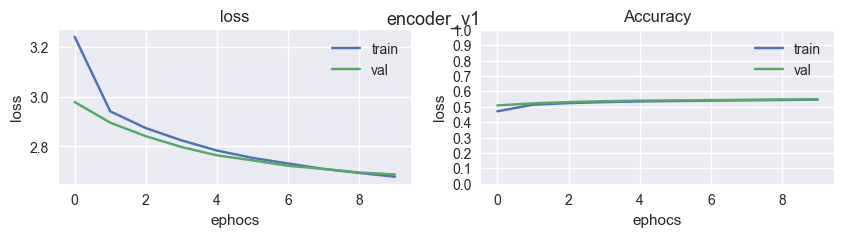

In [102]:
for i, model in enumerate(models_list):
    plt.figure(figsize=(10,2))


    plt.subplot(1, 2, 1)

    plt.suptitle(f"{model.name}", fontsize=13)


    plt.grid(True)
    plt.title(f"loss")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='val')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.grid(True)
    plt.title(f"Accuracy")
    plt.ylabel('loss')
    plt.xlabel('ephocs')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='val')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()

    plt.show()

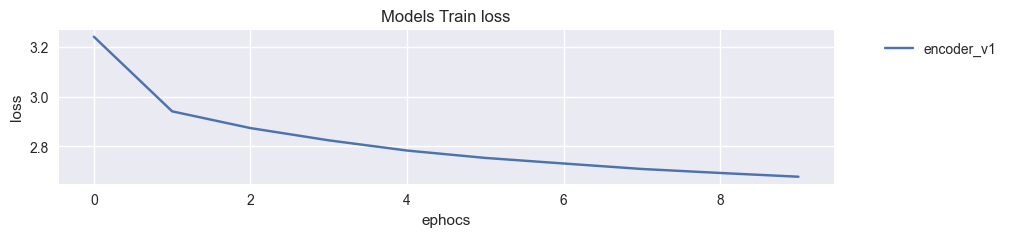

In [103]:
plt.figure(figsize=(10,2))
plt.title(f"Models Train loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)
plt.show()

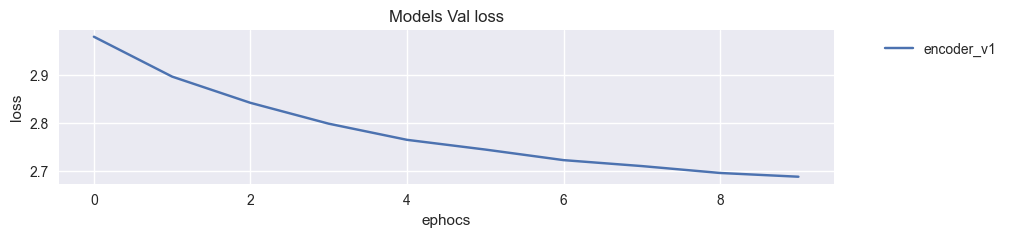

In [104]:
plt.figure(figsize=(10,2))
plt.title(f"Models Val loss")
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('ephocs')

for i, model in enumerate(models_list):
    plt.plot(model.history['val_loss'], label=model.name)

plt.legend(bbox_to_anchor=(1.05, 1),
            loc="upper left",)

plt.show()

# Inference

In [105]:
best_model_name = "encoder_v1"
best_model = list(filter(lambda x: x.name == best_model_name, models_list))[0]
print(best_model)

In [109]:
def predict_txt_yield(input_prompt, best_model, iterations, sample_p = True):

    padded_prompt_words = clean_poem_text(input_prompt).split(' ')

    yield compose_poem_text(input_prompt)

    while len(padded_prompt_words) < WINDOW_SIZE :
        padded_prompt_words = [START_TOKEN] + padded_prompt_words

    while(len(padded_prompt_words) > WINDOW_SIZE):
        padded_prompt_words = padded_prompt_words[1:]

    for i in range(iterations):
        cur_input_prompt = [CLS_TOKEN] + padded_prompt_words

        padded_prompt_tokenized = tokenizer.texts_to_sequences([cur_input_prompt])[0]

        padded_prompt_tokenized = np.array([padded_prompt_tokenized])
        pro_output =  best_model.predict(padded_prompt_tokenized, verbose = 0)[0]

        if sample_p:
            ch_num = np.random.choice(len(pro_output), p=pro_output)
        else:
            ch_num = np.argmax(pro_output)

        ch = tokenizer.sequences_to_texts([[ch_num]])[0]

        padded_prompt_words = padded_prompt_words[1:] + [ch]

        if ch != CONCAT_TOKEN:
          yield " "
          yield ch


In [110]:
def predict_txt_one_shot(input_prompt, best_model, iterations, sample_p = True):
    return_text = []

    padded_prompt_words = clean_poem_text(input_prompt).split(' ')

    return_text.extend(padded_prompt_words)

    while len(padded_prompt_words) < WINDOW_SIZE :
        padded_prompt_words = [START_TOKEN] + padded_prompt_words

    while(len(padded_prompt_words) > WINDOW_SIZE):
        padded_prompt_words = padded_prompt_words[1:]

    for i in range(iterations):
        cur_input_prompt = [CLS_TOKEN] + padded_prompt_words

        padded_prompt_tokenized = tokenizer.texts_to_sequences([cur_input_prompt])[0]

        padded_prompt_tokenized = np.array([padded_prompt_tokenized])
        pro_output =  best_model.predict(padded_prompt_tokenized, verbose = 0)[0]

        if sample_p:
            ch_num = np.random.choice(len(pro_output), p=pro_output)
        else:
            ch_num = np.argmax(pro_output)

        ch = tokenizer.sequences_to_texts([[ch_num]])[0]

        padded_prompt_words = padded_prompt_words[1:] + [ch]

        return_text.append(ch)
        
    
    return compose_poem_text(' '.join(return_text))


In [ ]:
for r in predict_txt_yield("يا ليل", best_model.model, 200, True):
    print(r,end='')

يا ليل جرت ل ي ب برق ال غيد 
 اهد ي من ل يل خد 
 يرتق ي ضرب ال ذنوب ل ه 
 تروح ف ي ه ا ف ي قلوب ه ا 
 ل يل ي عل ي ك ل يوم ال ل يل 
 جلت عن علي ال ل ه و و ال مكاسب 
 ال ي ال حاد ثات ب ل ا ضريب هم 
 و ك وثر ن ا ال جماد انار تان 
 ب ياض مقوم و حم جمام 
 و ل ا امور ب ذكر ال نوال هبيط 
 و قد قيل ل م اد عز ل حنتم 
 س م ا انت ال ام ال تاييد هيم 
 انم ا ك رم ال ل ه جل ذمام 
 من ك ان ينحسم ال جود و عل ا 
 توديع

In [119]:
print(predict_txt_one_shot("باسل", best_model.model, 100, True))

باسل ديار لقاك السرور مسرجا 
 ولا تكفرولكن الموي لم يجد 
 وحدي شاعر بيني ملان 
 يجعل الناس لليل حين نزت 
 لا يعرف ماء قصب الاياطل 
 فاذا ما الليل يفرعن في بروج
 و
